In [1]:

import json
import os
import torch
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
from torch.cuda import amp
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2 
# import radtts
import os
import json
from timeit import default_timer as timer
os.chdir('/usr/src/app/radtts')
from distributed import (init_distributed, apply_gradient_allreduce,
                         reduce_tensor)

from radtts import RADTTS
from train import RADTTSLoss, AttentionBinarizationLoss, prepare_dataloaders, prepare_model_weights, parse_data_from_batch, compute_validation_loss
import torch
# from radtts.inference import load_vocoder
from hifigan_env import AttrDict
from data import Data
from hifigan_models import Generator
from hifigan_env import AttrDict
from hifigan_denoiser import Denoiser
from radam import RAdam
torch.cuda.set_device(1)

def get_s3_state_dict(s3_url):
    response = requests.get(s3_url, stream=True)
    bio = BytesIO(response.content)
    state_dict = torch.load(bio)
    return state_dict
#     model.load_state_dict(loaded["model"])

# s3_url = "https://uberduck-models.s3.us-west-1.amazonaws.com/radtts++ljs-dap.pt"
# s3_url = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/radtts%2B%2Bljs-dap.pt"
pretrained_dict = torch.load('/usr/src/app/radtts/radtts++ljs-dap (1).pt')['state_dict']


In [4]:
include_layers = []
ignore_layers_warmstart = []

model = RADTTS(
    **model_config,
)

if len(include_layers):
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if any(l in k for l in include_layers)}

if len(ignore_layers_warmstart):
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if all(l not in k for l in ignore_layers_warmstart)}

model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict, strict=False)

Applying spectral norm to text encoder LSTM
Applying spectral norm to context encoder LSTM


/usr/src/app/radtts/common.py:391: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/opt/conda/lib/python3.8/site-packages/torch/functional.py:1682: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/n

_IncompatibleKeys(missing_keys=[], unexpected_keys=['dur_pred_layer.bottleneck_layer.projection_fn.conv.bias', 'dur_pred_layer.bottleneck_layer.projection_fn.conv.weight_g', 'dur_pred_layer.bottleneck_layer.projection_fn.conv.weight_v', 'dur_pred_layer.feat_pred_fn.convolutions.0.bias', 'dur_pred_layer.feat_pred_fn.convolutions.0.weight_g', 'dur_pred_layer.feat_pred_fn.convolutions.0.weight_v', 'dur_pred_layer.feat_pred_fn.convolutions.1.bias', 'dur_pred_layer.feat_pred_fn.convolutions.1.weight_g', 'dur_pred_layer.feat_pred_fn.convolutions.1.weight_v', 'dur_pred_layer.feat_pred_fn.bilstm.weight_ih_l0', 'dur_pred_layer.feat_pred_fn.bilstm.bias_ih_l0', 'dur_pred_layer.feat_pred_fn.bilstm.bias_hh_l0', 'dur_pred_layer.feat_pred_fn.bilstm.weight_ih_l0_reverse', 'dur_pred_layer.feat_pred_fn.bilstm.bias_ih_l0_reverse', 'dur_pred_layer.feat_pred_fn.bilstm.bias_hh_l0_reverse', 'dur_pred_layer.feat_pred_fn.bilstm.weight_hh_l0_orig', 'dur_pred_layer.feat_pred_fn.bilstm.weight_hh_l0_reverse_orig',

In [8]:
from train import prepare_dataloaders
n_gpus = 1
batch_size = 6

train_loader, valset, collate_fn = prepare_dataloaders(
    data_config, n_gpus, batch_size)

i, batch = next(enumerate( train_loader))
model.zero_grad()
(mel, speaker_ids, text, in_lens, out_lens, attn_prior,
 f0, voiced_mask, p_voiced, energy_avg,
 audiopaths) = parse_data_from_batch(batch)


initializing training dataloader
Number of speakers: 1
Speaker IDS {'0': 0}
Number of files 100
Number of files after duration filtering 100
Dataloader initialized with no augmentations
initializing validation dataloader
Number of files 100
Number of files after duration filtering 100
Dataloader initialized with no augmentations


In [12]:
valset.get_text('your mom')

tensor([  8,  99,  89,  95,  92,   8, 155, 103, 155,   8])

<AxesSubplot:>

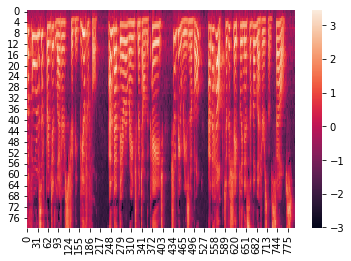

In [17]:
%matplotlib inline
import seaborn as sns
sns.heatmap(mel.detach().cpu().numpy()[0])

In [3]:
config = {
    "train_config": {
        "output_directory": "/lj_minimal_decoder",
        "epochs": 10000000,
        "optim_algo": "RAdam",
        "learning_rate": 1e-4,
        "weight_decay": 1e-6,
        "sigma": 1.0,
        "iters_per_checkpoint": 2500,
        "steps_per_sample": 200,
        "batch_size": 6,
        "seed": None,
        "checkpoint_path": "",
        "ignore_layers": [],
        "ignore_layers_warmstart": [],
        "finetune_layers": [],
        "include_layers": [],
        "vocoder_config_path": "/usr/src/app/radtts/models/hifigan_22khz_config.json",
        "vocoder_checkpoint_path": "/usr/src/app/radtts/models/hifigan_libritts100360_generator0p5.pt",
        "log_attribute_samples": False,
        "log_decoder_samples": True,
        "warmstart_checkpoint_path": "",
        "use_amp": False,
        "grad_clip_val": 1.0,
        "loss_weights": {
            "blank_logprob": -1,
            "ctc_loss_weight": 0.1,
            "binarization_loss_weight": 1.0,
            "dur_loss_weight": 1.0,
            "f0_loss_weight": 1.0,
            "energy_loss_weight": 1.0,
            "vpred_loss_weight": 1.0
        },
        "binarization_start_iter": 6000,
        "kl_loss_start_iter": 18000,
        "unfreeze_modules": "all"
    },
    "data_config": {
        "training_files": {
            "LJS": {
                "basedir": "/",
                "audiodir": "/usr/src/app/radtts/lj_for_upload/lj_for_upload/lj_data/LJSpeech-1.1/wavs",
                "filelist": "/usr/src/app/radtts/lj_for_upload/lj_for_upload/metadata_formatted_100.txt",
                "lmdbpath": ""
            }
        },
        "validation_files": {
            "LJS": {
                "basedir": "/",
                "audiodir": "/usr/src/app/radtts/lj_for_upload/lj_for_upload/lj_data/LJSpeech-1.1/wavs",
                "filelist": "/usr/src/app/radtts/lj_for_upload/lj_for_upload/metadata_formatted_100.txt",
                "lmdbpath": ""
            }
        },
        "dur_min": 0.1,
        "dur_max": 10.2,
        "sampling_rate": 22050,
        "filter_length": 1024,
        "hop_length": 256,
        "win_length": 1024,
        "n_mel_channels": 80,
        "mel_fmin": 0.0,
        "mel_fmax": 8000.0,
        "f0_min": 80.0,
        "f0_max": 640.0,
        "max_wav_value": 32768.0,
        "use_f0": True,
        "use_log_f0": 0,
        "use_energy_avg": True,
        "use_scaled_energy": True,
        "symbol_set": "radtts",
        "cleaner_names": ["radtts_cleaners"],
        "heteronyms_path": "tts_text_processing/heteronyms",
        "phoneme_dict_path": "tts_text_processing/cmudict-0.7b",
        "p_phoneme": 1.0,
        "handle_phoneme": "word",
        "handle_phoneme_ambiguous": "ignore",
        "include_speakers": None,
        "n_frames": -1,
        "betabinom_cache_path": "data_cache/",
        "lmdb_cache_path": "", 
        "use_attn_prior_masking": True,
        "prepend_space_to_text": True,
        "append_space_to_text": True,
        "add_bos_eos_to_text": False,
        "betabinom_scaling_factor": 1.0,
        "distance_tx_unvoiced": False,
        "mel_noise_scale": 0.0
    },
    "model_config": {
        "n_speakers": 1,
        "n_speaker_dim": 16,
        "n_text": 185,
        "n_text_dim": 512,
        "n_flows": 8,
        "n_conv_layers_per_step": 4,
        "n_mel_channels": 80,
        "n_hidden": 1024,
        "mel_encoder_n_hidden": 512,
        "dummy_speaker_embedding": False,
        "n_early_size": 2,
        "n_early_every": 2,
        "n_group_size": 2,
        "affine_model": "wavenet",
        "include_modules": "decatnvpred",
        "scaling_fn": "tanh",
        "matrix_decomposition": "LUS",
        "learn_alignments": True,
        "use_speaker_emb_for_alignment": False,
        "attn_straight_through_estimator": True,
        "use_context_lstm": True,
        "context_lstm_norm": "spectral",
        "context_lstm_w_f0_and_energy": True,
        "text_encoder_lstm_norm": "spectral",
        "n_f0_dims": 1,
        "n_energy_avg_dims": 1,
        "use_first_order_features": False,
        "unvoiced_bias_activation": "relu",
        "decoder_use_partial_padding": True,
        "decoder_use_unvoiced_bias": True,
        "ap_pred_log_f0": True,
        "ap_use_unvoiced_bias": True,
        "ap_use_voiced_embeddings": True,
        "dur_model_config": None,
        "f0_model_config": None,
        "energy_model_config": None,
        "v_model_config": {
            "name": "dap",
            "hparams": {
                "n_speaker_dim": 16,
                "take_log_of_input": False,
                "bottleneck_hparams": {
                    "in_dim": 512,
                    "reduction_factor": 16,
                    "norm": "weightnorm",
                    "non_linearity": "relu"
                },
                "arch_hparams": {
                    "out_dim": 1,
                    "n_layers": 2,
                    "n_channels": 256,
                    "kernel_size": 3,
                    "p_dropout": 0.5,
                    "lstm_type": "",
                    "use_linear": 1
                }
            }
        }
    }
}

train_config = config['train_config']
model_config = config['model_config']
data_config = config['data_config']
